In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(320, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        # shape of x : (-1, 1, 28, 28)
        # shape is of format (batch size, depth, height, width)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # shape of x: (-1, 10, 12, 12)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # shape after self.conv2_drop(self.conv2(x)): (-1, 20, 8, 8)
        # shape after relu, F.max_pool_2d: (-1, 20, 4, 4)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        # shape of x: (-1, 200)
        x = F.dropout(x, training=self.training)
        # shape pf x: (-1, 200)
        x = self.fc2(x)
        # shape of x: (-1, 10)
        return F.log_softmax(x, dim=1)
        
        

In [3]:
  
class Log_reg(nn.Module):
    def __init__(self):
        super(Log_reg, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        
    def forward(self, x):
        # shape of x: (-1, 1, 28, 28)
        x = x.view(-1, 784)
        # (-1, 784)
        x = F.log_softmax(self.fc1(x))
        # (-1, 10)
        return x

In [4]:
class two_layer_net(nn.Module):
    def __init__(self):
        super(two_layer_net, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)
        self.nonlinearity = F.relu
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.nonlinearity(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        return x

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # This loop iterates through the dataset
        data, target = data.to(device), target.to(device)
        # this moves data, target to gpu if you have one
        optimizer.zero_grad()
        # Delete previous gradients
        output = model(data)
        # Forward pass through the model
        # This calls model.forward(data)
        loss = F.nll_loss(output, target)
        # negative log likelyhood loss
        loss.backward()
        # Computes backward pass, computes gradients
        optimizer.step()
        # Performs gradient update
        if batch_idx % 6400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
train_X = torch.from_numpy(np.load("train.npy")).float()
train_Y = torch.from_numpy(np.load("train_labels.npy")).long()
test_X = torch.from_numpy(np.load("test.npy")).float()
test_Y = torch.from_numpy(np.load("test_labels.npy")).long()

train_dataset = data.TensorDataset(train_X, train_Y)
test_dataset = data.TensorDataset(test_X, test_Y)

    
use_cuda = torch.cuda.is_available()
#use_cuda = False
lr = 0.001
momentum = 0.5

epochs = 10
torch.manual_seed(2)
model_type="uytjyutoiuyt"

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=64, shuffle=True, **kwargs)

if model_type == "network":
    model = Net().to(device)
elif model_type == "two_layer":
    model = two_layer_net().to(device)
else:
    model = Log_reg().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
        
if (model_type != "network"):
    thing = model.fc1
    
"""
SAVING
torch.save(model.state_dict(), "path_to_network")

LOADING
model.load_state_dict(torch.load("path_to_network"))
"""

<ipython-input-3-c72de7633b24>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc1(x))


Train Epoch: 1 [0/60000 (0%)]	Loss: 81.274529

Test set: Average loss: 32.5426, Accuracy: 8238/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 32.197708

Test set: Average loss: 29.7800, Accuracy: 8354/10000 (84%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 29.167500

Test set: Average loss: 24.9429, Accuracy: 8714/10000 (87%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 17.504440

Test set: Average loss: 32.7921, Accuracy: 8402/10000 (84%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 19.006098

Test set: Average loss: 38.9685, Accuracy: 8211/10000 (82%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 42.776279

Test set: Average loss: 33.2622, Accuracy: 8504/10000 (85%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 21.071070

Test set: Average loss: 18.7731, Accuracy: 9017/10000 (90%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 15.347431

Test set: Average loss: 28.6812, Accuracy: 8603/10000 (86%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 22.974728

Test set: Average loss: 25.4299, Accuracy: 8800/10000 (88%)

Train Epoch: 10 [0/60000 (0%

'\nSAVING\ntorch.save(model.state_dict(), "path_to_network")\n\nLOADING\nmodel.load_state_dict(torch.load("path_to_network"))\n'

['__call__', '__class__', '__constants__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bias', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'in_features', 'load_state_dict', 'modules', 'named_buffers', 'named_children', 'nam

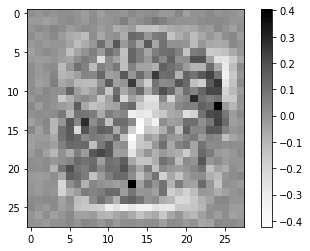

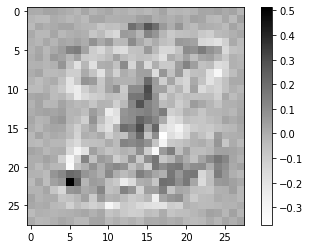

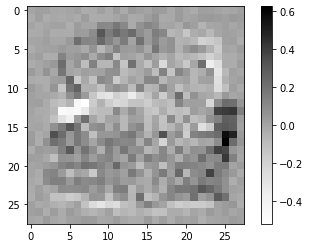

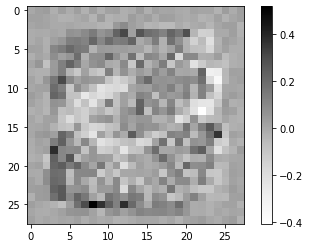

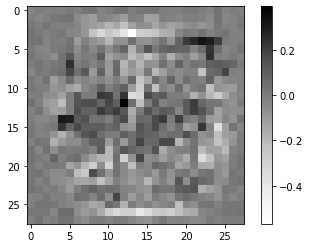

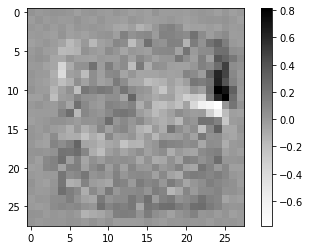

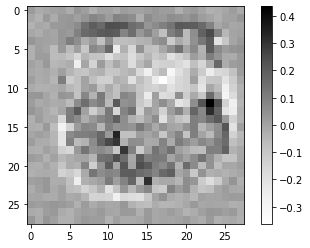

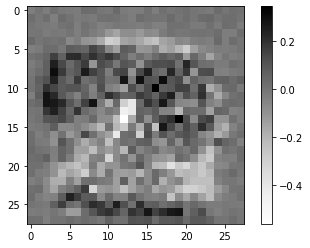

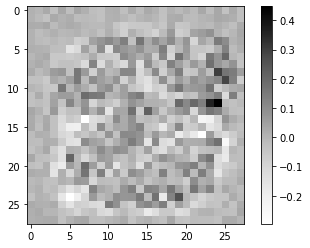

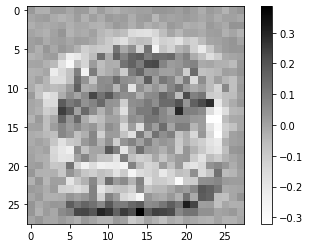

In [8]:
import numpy as np
print(dir(model.fc1))
w = model.fc1.weight
mats = []
for i in range(10):
    weights = w[i].reshape((28,28)).cpu().data.numpy()
    """
    weights[np.greater(weights, 0.03)] = 1
    weights[np.less(weights, -0.03)] = -1
    weights[np.less(weights, 0.03) * np.greater(weights, -0.03)] = 0
    """
    mats.append(weights)
    
import matplotlib
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure()
    plt.imshow(mats[i], cmap='Greys')
    plt.colorbar()
    plt.show()